In [1]:
%matplotlib inline

### Prepare esgf search connection

See also http://esgf-pyclient.readthedocs.io/en/latest/examples.html

In [2]:
from pyesgf.search import SearchConnection
conn = SearchConnection('http://esgf-data.dkrz.de/esg-search', distrib=False)

### run a query for CORDEX datasets and show facets

In [3]:
ctx = conn.new_context(project='CORDEX', query='temperature')
print 'Hits:', ctx.hit_count
print 'Institute:'
ctx.facet_counts['institute']

Hits: 2816
Institute:


{u'AWI': 26,
 u'CLMcom': 570,
 u'DHMZ': 16,
 u'DMI': 580,
 u'GERICS': 133,
 u'HMS': 93,
 u'KNMI': 505,
 u'MPI-CSC': 665,
 u'ULg': 38,
 u'UQAM': 190}

### use facet search ...

In [4]:
ctx = conn.new_context(project='CORDEX', institute='MPI-CSC', experiment='historical', time_frequency='day')
print 'Hits:', ctx.hit_count
print 'Domain:', ctx.facet_counts['domain']
print 'Ensembles:', ctx.facet_counts['ensemble']
print 'Variable:', ctx.facet_counts['variable']


Hits: 378
Domain: {u'EUR-11': 94, u'AFR-44': 94, u'WAS-44': 48, u'WAS-44i': 48, u'EUR-44': 94}
Ensembles: {u'r2i1p1': 94, u'r1i1p1': 237, u'r12i1p1': 47}
Variable: {u'prc': 8, u'tas': 8, u'uas': 8, u'huss': 8, u'hfss': 8, u'ua200': 8, u'prw': 2, u'zg200': 8, u'prsn': 8, u'rsus': 8, u'hus850': 8, u'pr': 8, u'rlut': 8, u'ua500': 8, u'rlus': 8, u'rlds': 8, u'ua850': 8, u'ts': 8, u'mrso': 8, u'sic': 8, u'clt': 8, u'vas': 8, u'snd': 8, u'va200': 8, u'psl': 8, u'va850': 8, u'ta200': 8, u'snm': 8, u'mrros': 8, u'snw': 8, u'rsds': 8, u'ta500': 8, u'zg500': 8, u'wsgsmax': 8, u'rsdt': 8, u'sfcWindmax': 8, u'mrro': 8, u'evspsbl': 8, u'sfcWind': 8, u'tauv': 8, u'tasmin': 8, u'tauu': 8, u'tasmax': 8, u'va500': 8, u'hfls': 8, u'ta850': 8, u'rsut': 8, u'ps': 8}


### add more constraints to select a single dataset

In [5]:
ctx = ctx.constrain(domain='EUR-11', ensemble='r1i1p1', variable='tasmax')
print 'Hits:', ctx.hit_count


Hits: 1


### use aggregation context and get opendap url 

In [6]:
result = ctx.search()[0]
agg_ctx = result.aggregation_context()
agg = agg_ctx.search()[0]
print agg.opendap_url

http://esgf1.dkrz.de/thredds/dodsC/cordex.output.EUR-11.MPI-CSC.MPI-M-MPI-ESM-LR.historical.r1i1p1.REMO2009.v1.day.tasmax.tasmax.20160419.aggregation


### use logon manager to get proxy certificate and prepare secured opendap access

In [7]:
from pyesgf.logon import LogonManager
lm = LogonManager()
lm.logoff()
lm.is_logged_on()

False

... logon on now with you username and password:

In [8]:
lm.logon(hostname="esgf-data.dkrz.de", bootstrap=True, interactive=True)

Enter myproxy username:pingutest1
Enter password for pingutest1: ········



In [9]:
lm.is_logged_on()

True

this updates you proxy certificate in `~/.esg/` and prepares a `~/.dodsrc` config file for secured opendap access. 

### use python netCDF4 to access opendap data

see http://unidata.github.io/netcdf4-python/

In [10]:
from netCDF4 import Dataset

ds = Dataset(agg.opendap_url, 'r')

show attributes:

In [11]:
ds.ncattrs()

ds.getncattr('experiment')

u'historical'

show variables:

In [12]:
ds.variables.keys()

[u'rlat',
 u'rlon',
 u'rotated_latitude_longitude',
 u'lat_vertices',
 u'lon_vertices',
 u'height',
 u'time',
 u'time_bnds',
 u'lat',
 u'lon',
 u'tasmax']

details about time variable:

In [13]:
ds.variables['time']

<type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    units: days since 1949-12-01T00:00:00Z
    calendar: proleptic_gregorian
    axis: T
    long_name: time
    standard_name: time
    _ChunkSizes: 524288
unlimited dimensions: 
current shape = (20453,)
filling off

show details about tasmax:

In [14]:
ds.variables['tasmax']

<type 'netCDF4._netCDF4.Variable'>
float32 tasmax(time, rlat, rlon)
    standard_name: air_temperature
    long_name: Daily Maximum Near-Surface Air Temperature
    comment: daily-maximum near-surface (usually, 2 meter) air temperature.
    units: K
    cell_methods: time: maximum
    history: 2016-02-01T11:17:01Z altered by CMOR: Treated scalar dimension: 'height'.
    coordinates: height lat lon
    missing_value: 1e+20
    _FillValue: 1e+20
    associated_files: gridspecFile: gridspec_atmos_fx_MPI-CSC-REMO2009_historical_r0i0p0.nc
    grid_mapping: rotated_latitude_longitude
    _ChunkSizes: [  1 412 424]
unlimited dimensions: 
current shape = (20453, 412, 424)
filling off

### Create a plot of the first timestep using cartopy

see http://scitools.org.uk/cartopy/docs/latest/matplotlib/advanced_plotting.html?highlight=netcdf

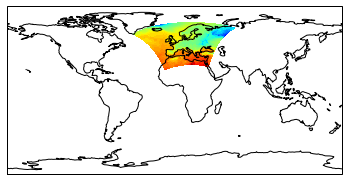

In [15]:
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs

timestep = 0

tasmax = ds.variables['tasmax'][timestep, :, :]
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()

fig = plt.contourf(lons, lats, tasmax, 60, transform=ccrs.PlateCarree())
#plt.show()

### Clip the bounding box and plot it ...

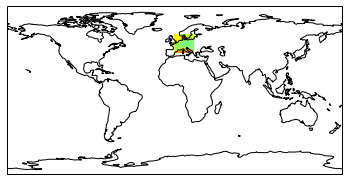

In [16]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
plt.contourf(lons.clip(min=0, max=20), lats.clip(min=40, max=60), tasmax, 60, transform=ccrs.PlateCarree())
#plt.show()

### Write netcdf file with a given subset (boundingbox, time)

One needs to create a new Dataset object and copy all the attributes and data needed. This is a bit lengthly.

See the following example:

http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html

### Use nco to write netcdf file for a subset

    ncks -O -d time,0,0 http://esgf1.dkrz.de/thredds/dodsC/cordex.output.EUR-11.MPI-CSC.MPI-M-MPI-ESM-LR.historical.r1i1p1.REMO2009.v1.day.tasmax.tasmax.20160419.aggregation -o test.nc


### Use nco python wrapper

In [17]:
from nco import Nco
nco = Nco()

subset first timestamp

In [18]:
nc_out = '/tmp/out.nc'
nco.ncks(input=str(agg.opendap_url), output=nc_out, options="-O -d time,0,0 -d rlon,0,20 -d rlat,40,60 --netcdf4")

'/tmp/out.nc'

### show output with cdo

In [19]:
from cdo import Cdo
cdo = Cdo()

In [20]:
cdo.sinfo(input=nc_out)

[u'File format : netCDF4',
 u'-1 : Institut Source   Ttype    Levels Num    Points Num Dtype : Parameter ID',
 u'1 : unknown  MPI-CSC-REMO2009 instant       1   1       441   1  F32  : -1',
 u'Grid coordinates :',
 u'1 : curvilinear              : points=441 (21x21)',
 u'lon : -13.1062 to -9.94999 degrees_east',
 u'lat : 26.0437 to 28.8984 degrees_north',
 u'available : cellbounds',
 u'Vertical coordinates :',
 u'1 : height                   : levels=1',
 u'height : 2 m',
 u'Time coordinate :  1 step',
 u'RefTime =  1949-12-01 00:00:00  Units = days  Calendar = proleptic_gregorian  Bounds = true',
 u'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 u'1950-01-02 12:00:00']

In [21]:
cdo.showname(input=nc_out)

[u'tasmax']

### Convert to CSV

client:

* https://www.wakari.io/sharing/bundle/rsignell/cf_3d_to_1d
* http://stackoverflow.com/questions/28420988/how-to-read-netcdf-file-and-write-to-csv-using-python

server:

* http://www.pydap.org/responses.html#excel-spreadsheet